# Standard procedure

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

xarray: 0.14.2.dev62+g6d1434e9, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py


pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Create a model

Let's import the Profile Classification Model (PCM) constructor:

In [2]:
from pyxpcm.models import pcm

In [3]:
z = np.arange(0.,-1000,-10.)
pcm_features = {'temperature': z, 'salinity':z}

We can now instantiate a PCM, say with 8 classes:

In [4]:
m = pcm(K=8, features=pcm_features)
m

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

## Load training data

In [5]:
import pyxpcm
ds = pyxpcm.tutorial.open_dataset('argo').load()
print(ds)

<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 ...
    LONGITUDE  (N_PROF) float32 ...
    TIME       (N_PROF) datetime64[ns] ...
    DBINDEX    (N_PROF) float64 ...
    TEMP       (N_PROF, DEPTH) float32 ...
    PSAL       (N_PROF, DEPTH) float32 ...
    SIG0       (N_PROF, DEPTH) float32 ...
    BRV2       (N_PROF, DEPTH) float32 ...
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source DOI:          10.17882/42182


## Fit the model on data

In [6]:
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

In [7]:
features_zdim='DEPTH'

Now we're ready to fit the model on the this dataset:

In [8]:
m.fit(ds, features=features_in_ds, dim=features_zdim)
m 

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 38.825075

## Classify data

Now that the PCM is fitted, we can predict the classification results like:

In [9]:
m.predict(ds, features=features_in_ds, inplace=True)
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Data variables:
    LATITUDE    (N_PROF) float32 ...
    LONGITUDE   (N_PROF) float32 ...
    TIME        (N_PROF) datetime64[ns] ...
    DBINDEX     (N_PROF) float64 ...
    TEMP        (N_PROF, DEPTH) float32 27.422163 27.422163 ... 4.391791
    PSAL        (N_PROF, DEPTH) float32 36.35267 36.35267 ... 34.910286
    SIG0        (N_PROF, DEPTH) float32 ...
    BRV2        (N_PROF, DEPTH) float32 ...
    PCM_LABELS  (N_PROF) int64 3 3 3 3 3 3 3 3 3 3 3 3 ... 5 5 5 5 5 5 5 5 5 5 5
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source DOI:          10.17882/42182

Prediction labels are automatically added to the dataset as ``PCM_LABELS`` because the option ``inplace`` was set to ``True``. We didn't specify the ``dim`` option because our dataset is CF compliant.

pyXpcm use a GMM classifier by default, which is a fuzzy classifier. So we can also predict the probability of each classes for all profiles, the so-called *posteriors*:

In [10]:
m.predict_proba(ds, features=features_in_ds, inplace=True)
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560, pcm_class: 8)
Coordinates:
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: pcm_class
Data variables:
    LATITUDE    (N_PROF) float32 ...
    LONGITUDE   (N_PROF) float32 ...
    TIME        (N_PROF) datetime64[ns] ...
    DBINDEX     (N_PROF) float64 ...
    TEMP        (N_PROF, DEPTH) float32 27.422163 27.422163 ... 4.391791
    PSAL        (N_PROF, DEPTH) float32 36.35267 36.35267 ... 34.910286
    SIG0        (N_PROF, DEPTH) float32 ...
    BRV2        (N_PROF, DEPTH) float32 ...
    PCM_LABELS  (N_PROF) int64 3 3 3 3 3 3 3 3 3 3 3 3 ... 5 5 5 5 5 5 5 5 5 5 5
    PCM_POST    (pcm_class, N_PROF) float64 3.806e-41 2.223e-41 ... 0.0
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source DOI:          10.17882/42182

In [11]:
print("Data variables BEFORE cleaning", ds.data_vars)

ds_after = ds.pyxpcm.drop_all() 
ds_pcm, _ = ds.pyxpcm.split() 

print("\nData variables AFTER cleaning", ds_after.data_vars)
print("\nData variables from pyXpcm", ds_pcm.data_vars)

Data variables BEFORE cleaning Data variables:
    LATITUDE    (N_PROF) float32 ...
    LONGITUDE   (N_PROF) float32 ...
    TIME        (N_PROF) datetime64[ns] ...
    DBINDEX     (N_PROF) float64 ...
    TEMP        (N_PROF, DEPTH) float32 27.422163 27.422163 ... 4.391791
    PSAL        (N_PROF, DEPTH) float32 36.35267 36.35267 ... 34.910286
    SIG0        (N_PROF, DEPTH) float32 ...
    BRV2        (N_PROF, DEPTH) float32 ...
    PCM_LABELS  (N_PROF) int64 3 3 3 3 3 3 3 3 3 3 3 3 ... 5 5 5 5 5 5 5 5 5 5 5
    PCM_POST    (pcm_class, N_PROF) float64 3.806e-41 2.223e-41 ... 0.0

Data variables AFTER cleaning Data variables:
    LATITUDE   (N_PROF) float32 ...
    LONGITUDE  (N_PROF) float32 ...
    TIME       (N_PROF) datetime64[ns] ...
    DBINDEX    (N_PROF) float64 ...
    TEMP       (N_PROF, DEPTH) float32 27.422163 27.422163 ... 4.391791
    PSAL       (N_PROF, DEPTH) float32 36.35267 36.35267 ... 34.909523 34.910286
    SIG0       (N_PROF, DEPTH) float32 ...
    BRV2       (N_

It is important to note that once the PCM is fitted, you can predict labels for any dataset, as long as it has the PCM features.

For instance, let's predict labels for a gridded dataset:

In [12]:
ds_gridded = pyxpcm.tutorial.open_dataset('isas_snapshot').load()
ds_gridded

<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61)
Coordinates:
  * latitude     (latitude) float32 30.023445 30.455408 ... 49.41288 49.737103
  * longitude    (longitude) float32 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    TEMP         (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    TEMP_ERR     (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    TEMP_PCTVAR  (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    PSAL         (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    PSAL_ERR     (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    PSAL_PCTVAR  (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    SST          (latitude, longitude) float32 dask.array<chunksize=(53, 61), meta=np.ndarray>

In [13]:
m.predict(ds_gridded, features={'temperature':'TEMP','salinity':'PSAL'}, dim='depth', inplace=True)
ds_gridded

<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61)
Coordinates:
  * latitude     (latitude) float64 30.02 30.46 30.89 ... 49.09 49.41 49.74
  * longitude    (longitude) float64 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    TEMP         (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    TEMP_ERR     (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    TEMP_PCTVAR  (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    PSAL         (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    PSAL_ERR     (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    PSAL_PCTVAR  (depth, latitude, longitude) float32 dask.array<chunksize=(152, 53, 61), meta=np.ndarray>
    SST          (latitude, longitude) float32 dask.array<chunksize=(53, 61), meta=np.ndarray>
    PCM_LABELS   (latitude, longitude) float64 3.0 3.0 3.0 3.0 ... 2.0 2.0 2.0

where you can see the adition of the ``PCM_LABELS`` variable.

## Vertical structure of classes

In [14]:
for vname in ['TEMP', 'PSAL']:
    ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560, pcm_class: 8, quantile: 3)
Coordinates:
  * pcm_class   (pcm_class) int64 0 1 2 3 4 5 6 7
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
  * quantile    (quantile) float64 0.05 0.5 0.95
Data variables:
    LATITUDE    (N_PROF) float32 27.122 27.818 27.452 26.976 ... 4.243 4.15 4.44
    LONGITUDE   (N_PROF) float32 -74.86 -75.6 -74.949 ... -1.263 -0.821 -0.002
    TIME        (N_PROF) datetime64[ns] 2008-06-23T13:07:30 ... 2013-03-09T14:52:58.124999936
    DBINDEX     (N_PROF) float64 1.484e+04 1.622e+04 ... 8.557e+03 1.063e+04
    TEMP        (N_PROF, DEPTH) float32 27.422163 27.422163 ... 4.391791
    PSAL        (N_PROF, DEPTH) float32 36.35267 36.35267 ... 34.910286
    SIG0        (N_PROF, DEPTH) float32 23.601229 23.601229 ... 27.685583
    BRV2        (N_PROF, DEPTH) float32 0.00029447526 ... 4.500769e-06
    PCM_LABELS  (N_PROF) int64 3 3 3 3 3 3 3 3 3 3 3 3 ... 5 5 5 5 5 5 5 5 5 5 5
    PCM_POST    (pcm_class, N_PROF) float64 3.806e-41 2.223e-41 ... 0.0
    TEMP_Q      (pcm_class, quantile, DEPTH) float64 11.19 11.19 ... 7.525 7.494
    PSAL_Q      (pcm_class, quantile, DEPTH) float64 35.13 35.13 ... 35.58 35.57
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source DOI:          10.17882/42182

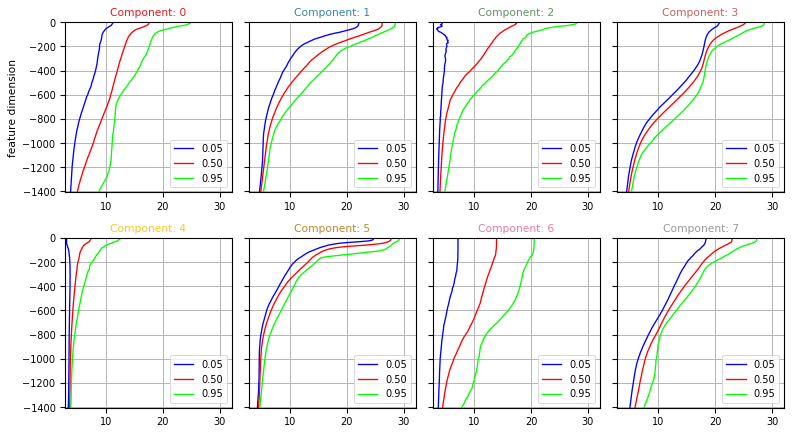

In [15]:
fig, ax = m.plot.quantile(ds['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)

## Geographic distribution of classes

A map of labels can now easily be plotted:

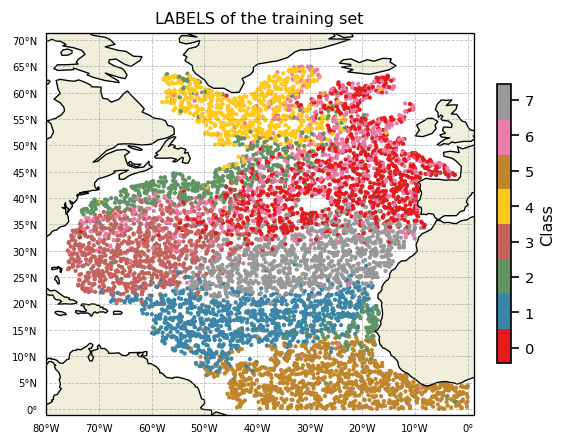

In [16]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set')
plt.show()

Since we predicted labels for 2 datasets, we can superimpose them

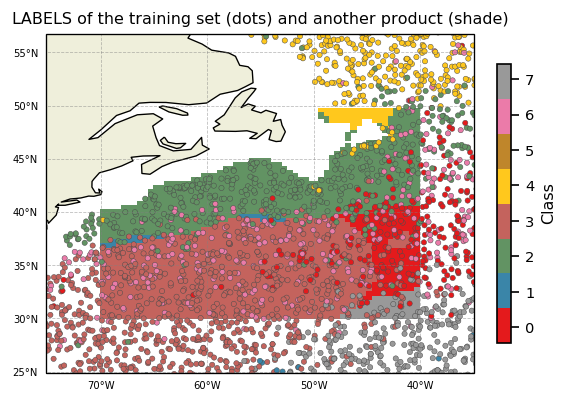

In [17]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-75,-35,25,55]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.pcolor(ds_gridded['longitude'], ds_gridded['latitude'], ds_gridded['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=10, c=ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K, edgecolors=[0.3]*3, linewidths=0.3)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set (dots) and another product (shade)')
plt.show()

*Posteriors* are defined for each data point and give the probability of that point to belong to any of the classes. It can be plotted this way:

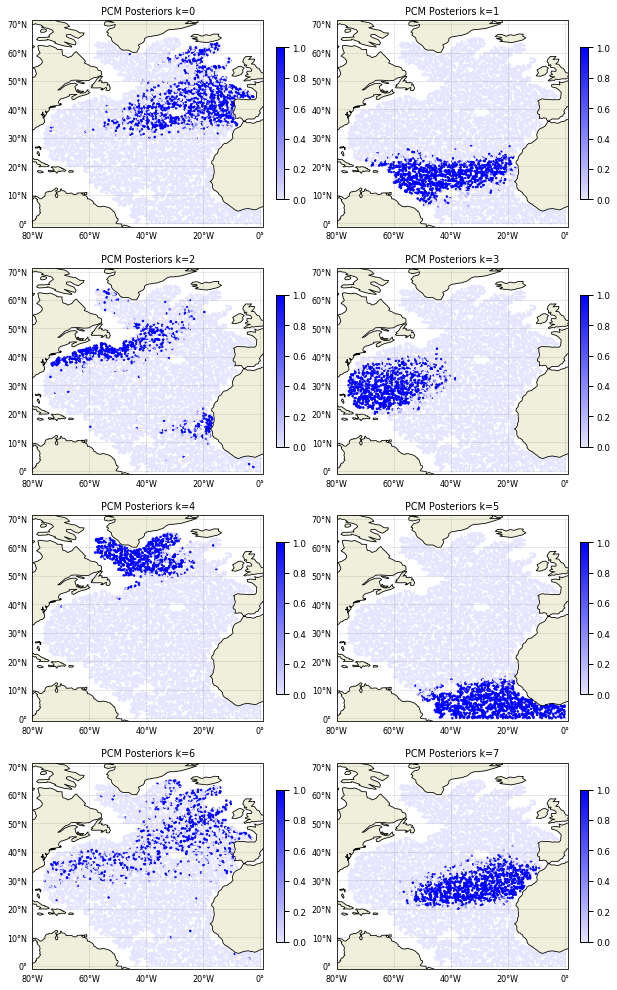

In [18]:
cmap = sns.light_palette("blue", as_cmap=True)
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = m.plot.subplots(figsize=(10,22), maxcols=2, subplot_kw=subplot_kw)

for k in m:
    sc = ax[k].scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_POST'].sel(pcm_class=k), 
                       cmap=cmap, transform=proj, vmin=0, vmax=1)
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    gl = m.plot.latlongrid(ax[k], fontsize=8, dx=20, dy=10)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].set_title('PCM Posteriors k=%i' % k)